In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates

In [2]:
data = pd.read_csv("doh-epi-dengue-data-2016-2021.csv")
data.drop([0],inplace=True)
data['cases'] = pd.to_numeric(data['cases'])
data.dropna(inplace=True)
data.head()

,loc,cases,deaths,date,Region
1,ALBAY,15,0,1/10/2016,REGION V-BICOL REGION
2,ALBAY,13,0,1/17/2016,REGION V-BICOL REGION
3,ALBAY,9,0,1/24/2016,REGION V-BICOL REGION
4,ALBAY,14,0,1/31/2016,REGION V-BICOL REGION
5,ALBAY,9,0,2/7/2016,REGION V-BICOL REGION


In [3]:
len(data['loc'].unique())

126

In [4]:
NCR_data = data[data['Region'] == 'NATIONAL CAPITAL REGION']
NCR_cities = list(data[data['Region'] == 'NATIONAL CAPITAL REGION']['loc'].unique())
dates = list(data['date'].unique())
neighbors = {
    'CALOOCAN CITY': ['MANILA CITY', 'NAVOTAS CITY', 'MALABON CITY', 'QUEZON CITY', 'VALENZUELA CITY'],
    'LAS PINAS CITY': ['MUNTINLUPA CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'MAKATI CITY': ['PASAY CITY', 'SAN JUAN CITY', 'PATEROS', 'TAGUIG CITY'],
    'MALABON CITY': ['CALOOCAN CITY', 'NAVOTAS CITY', 'VALENZUELA CITY', 'MANILA CITY'],
    'MANDALUYONG CITY': ['PASIG CITY', 'SAN JUAN CITY', 'MANILA CITY'],
    'MANILA CITY': ['CALOOCAN CITY', 'NAVOTAS CITY', 'MALABON CITY', 'SAN JUAN CITY', 'PASIG CITY', 'QUEZON CITY'],
    'MARIKINA CITY': ['PASIG CITY', 'QUEZON CITY'],
    'MUNTINLUPA CITY': ['LAS PINAS CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'NAVOTAS CITY': ['CALOOCAN CITY', 'MALABON CITY', 'MANILA CITY'],
    'PARANAQUE CITY': ['LAS PINAS CITY', 'MUNTINLUPA CITY', 'TAGUIG CITY', 'PASAY CITY'],
    'PASAY CITY': ['MAKATI CITY', 'MANILA CITY', 'PARANAQUE CITY', 'TAGUIG CITY'],
    'PASIG CITY': ['MANDALUYONG CITY', 'SAN JUAN CITY', 'MANILA CITY', 'MARIKINA CITY', 'PATEROS'],
    'PATEROS': ['MAKATI CITY', 'PASIG CITY', 'TAGUIG CITY'],
    'QUEZON CITY': ['CALOOCAN CITY', 'MANILA CITY', 'MARIKINA CITY', 'SAN JUAN CITY', 'MANDALUYONG CITY', 'VALENZUELA CITY'],
    'SAN JUAN CITY': ['MANILA CITY', 'MANDALUYONG CITY', 'PASIG CITY', 'QUEZON CITY'],
    'TAGUIG CITY': ['LAS PINAS CITY', 'MUNTINLUPA CITY', 'PARANAQUE CITY', 'PASAY CITY', 'MAKATI CITY', 'PATEROS'],
    'VALENZUELA CITY': ['CALOOCAN CITY', 'MALABON CITY', 'QUEZON CITY']
}

In [5]:
NCR_data['adjacent_cases'] = None
NCR_data_split = {}
for date in dates:
    NCR_data_split[date] = NCR_data[NCR_data['date'] == date]

D:\Temp\ipykernel_280\2081459970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NCR_data['adjacent_cases'] = None


In [6]:
for date in dates:
    def sum_adjacent_cases(city):
        if city in neighbors:
            adjacent_cities = neighbors[city]
            return NCR_data_split[date][NCR_data_split[date]['loc'].isin(adjacent_cities)]['cases'].sum()
        return 0
    NCR_data_split[date]['adjacent_cases'] = NCR_data_split[date]['loc'].apply(sum_adjacent_cases)

D:\Temp\ipykernel_280\1395326117.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NCR_data_split[date]['adjacent_cases'] = NCR_data_split[date]['loc'].apply(sum_adjacent_cases)


In [7]:
NCR_data = pd.concat(NCR_data_split.values(), ignore_index=True)
NCR_data.head()

,loc,cases,deaths,date,Region,adjacent_cases
0,CALOOCAN CITY,27,0,1/10/2016,NATIONAL CAPITAL REGION,157
1,LAS PINAS CITY,15,0,1/10/2016,NATIONAL CAPITAL REGION,50
2,MAKATI CITY,10,0,1/10/2016,NATIONAL CAPITAL REGION,31
3,MALABON CITY,26,0,1/10/2016,NATIONAL CAPITAL REGION,100
4,MANDALUYONG CITY,4,0,1/10/2016,NATIONAL CAPITAL REGION,79


In [8]:
def forecast(model, data, weeks_ahead):

    # Iteratively forecast future cases using an XGBoost model and lag features.

    # Define the lags (in weeks) to use for features
    weeks_lag = [1, 5, 26, 52]
    
    # Make a copy of the original data to preserve historical values
    forecast_data = data.copy()
    
    # Record the initial length so we know which rows are forecasts
    base_len = len(forecast_data)
    
    for i in range(weeks_ahead):
        new_row = {}  # will hold feature values for the new (to-be-predicted) week
        
        # Determine the new row's date and month
        if isinstance(forecast_data.index, pd.DatetimeIndex):
            new_date = forecast_data.index[-1] + pd.DateOffset(weeks=1)
            new_row['month'] = new_date.month
        else:
            # If no DateTimeIndex, we simply carry forward the last known month
            new_row['month'] = forecast_data['month'].iloc[-1]
        
        # For each defined lag, compute the required lag features.
        for lag in weeks_lag:
            # Only compute if we have enough history; otherwise, use NaN.
            if len(forecast_data) >= lag:
                # Direct lag of 'cases'
                new_row[f"cases {lag}w lag"] = forecast_data['cases'].iloc[-lag]
                
                # Create a shifted series for the lag; then compute rolling metrics with a window of 6 weeks.
                shifted = forecast_data['cases'].shift(lag)
                new_row[f"6w skew cases {lag}w lag"] = shifted.rolling(window=6).skew().iloc[-1]
                new_row[f"6w std cases {lag}w lag"] = shifted.rolling(window=6).std().iloc[-1]
                new_row[f"6wma cases {lag}w lag"] = shifted.rolling(window=6).mean().iloc[-1]
            else:
                new_row[f"cases {lag}w lag"] = np.nan
                new_row[f"6w skew cases {lag}w lag"] = np.nan
                new_row[f"6w std cases {lag}w lag"] = np.nan
                new_row[f"6wma cases {lag}w lag"] = np.nan
        
        # Convert the new row (features only) into a DataFrame
        new_row_df = pd.DataFrame([new_row])
        
        # Create a DMatrix and make the forecast using the model
        dmatrix = xgb.DMatrix(new_row_df)
        pred = model.predict(dmatrix)[0]
        
        # Add the forecasted 'cases' value into new_row so that future lag features can use it.
        new_row['cases'] = pred
        
        # Determine the new index value (either a new date or the next integer)
        if isinstance(forecast_data.index, pd.DatetimeIndex):
            new_index = new_date
        else:
            new_index = forecast_data.index[-1] + 1
        
        # Append the new row (with predicted cases) to forecast_data for subsequent iterations.
        new_row_df_with_cases = pd.DataFrame([new_row], index=[new_index])
        forecast_data = pd.concat([forecast_data, new_row_df_with_cases])
    
    # Return only the forecasted part
    forecasted_df = forecast_data.iloc[base_len:]
    return forecasted_df


In [9]:
def get_month(date):
    return int(str(date).split('/')[0])
NCR_data['month'] = NCR_data['date'].apply(get_month)
NCR_data['date'] = pd.to_datetime(NCR_data['date'], dayfirst=False, errors='coerce')
NCR_data.sort_values(by='date',inplace=True)

In [10]:
NCR_model_data = NCR_data.drop(columns=['deaths', 'Region', 'adjacent_cases'])
NCR_model_data.head()

,loc,cases,date,month
0,CALOOCAN CITY,27,2016-01-10,1
16,VALENZUELA CITY,17,2016-01-10,1
15,TAGUIG CITY,18,2016-01-10,1
14,SAN JUAN CITY,4,2016-01-10,1
13,QUEZON CITY,58,2016-01-10,1


In [ ]:
alpha = 0.2  # Underprediction errors (u > 0) are penalized with weight 1 - alpha = 0.7.
a = 5      # Threshold for the negative side.
b = 2    # Threshold for the positive side.

def generalized_huber_loss(preds, dtrain):
    # Custom generalized Huber loss for XGBoost.

    y = dtrain.get_label()
    u = y - preds  # Compute residuals.

    # Initialize gradient and Hessian arrays.
    grad = np.zeros_like(u)
    hess = np.zeros_like(u)

    # Region 1: Moderate errors: -a <= u <= b.
    mask_mid = (u >= -a) & (u <= b)
    # For u >= 0: weight = (1 - alpha), for u < 0: weight = alpha.
    mask_mid_pos = mask_mid & (u >= 0)
    mask_mid_neg = mask_mid & (u < 0)
    grad[mask_mid_pos] = -(1 - alpha) * u[mask_mid_pos]
    grad[mask_mid_neg] = -alpha * u[mask_mid_neg]
    hess[mask_mid_pos] = (1 - alpha)
    hess[mask_mid_neg] = alpha

    # Region 2: Underpredictions beyond b (u > b): loss = (1 - alpha)*b*(u - b/2).
    mask_pos = u > b
    grad[mask_pos] = -(1 - alpha) * b
    hess[mask_pos] = 0.0

    # Region 3: Overpredictions beyond -a (u < -a): loss = -alpha*a*(u + 1/(2a)).
    mask_neg = u < -a
    grad[mask_neg] = -(-alpha * a)  # Simplifies to alpha * a (note: derivative is constant).
    # But note: since loss = -alpha*a*(u + 1/(2a)), derivative with respect to u is -alpha*a.
    # Then gradient with respect to f is - (d(loss)/du) = alpha*a.
    grad[mask_neg] = alpha * a
    hess[mask_neg] = 0.0

    return grad, hess

In [12]:
mnl_model_data = NCR_model_data[NCR_model_data['loc'] == 'MANILA CITY']
weeks_lag = [1, 5, 26, 52]
for lag in weeks_lag:
    mnl_model_data[f"cases {lag}w lag"] = mnl_model_data['cases'].shift(lag)
    # NCR_data[f"adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].shift(lag)
    mnl_model_data[f"6w skew cases {lag}w lag"] = mnl_model_data['cases'].shift(lag).rolling(window=6).skew()
    mnl_model_data[f"6w std cases {lag}w lag"] = mnl_model_data['cases'].shift(lag).rolling(window=6).std()
    mnl_model_data[f"6wma cases {lag}w lag"] = mnl_model_data['cases'].shift(lag).rolling(window=6).mean()
    # NCR_data[f"3wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=3).mean()
    # NCR_data[f"6wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=6).mean()
mnl_model_data.dropna(inplace=True)
mnl_model_data.set_index('date',inplace=True)
mnl_model_data.drop(columns = ['loc'],inplace=True)
mnl_model_data = mnl_model_data.apply(pd.to_numeric, errors='coerce')
mnl_model_data = mnl_model_data[mnl_model_data.index < '2020-03-01']
mnl_model_data = mnl_model_data.asfreq('W')
mnl_model_data['cases'] = mnl_model_data['cases'].interpolate()
mnl_model_data.head(10)

D:\Temp\ipykernel_280\741012744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnl_model_data[f"cases {lag}w lag"] = mnl_model_data['cases'].shift(lag)
D:\Temp\ipykernel_280\741012744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnl_model_data[f"6w skew cases {lag}w lag"] = mnl_model_data['cases'].shift(lag).rolling(window=6).skew()
D:\Temp\ipykernel_280\741012744.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,cases,month,cases 1w lag,6w skew cases 1w lag,6w std cases 1w lag,6wma cases 1w lag,cases 5w lag,6w skew cases 5w lag,6w std cases 5w lag,6wma cases 5w lag,cases 26w lag,6w skew cases 26w lag,6w std cases 26w lag,6wma cases 26w lag,cases 52w lag,6w skew cases 52w lag,6w std cases 52w lag,6wma cases 52w lag
date,,,,,,,,,,,,,,,,,,
2017-02-19,34.0,2.0,43.0,-0.173059,8.704405,47.166667,59.0,0.261028,11.483321,43.666667,57.0,0.579586,22.444747,52.833333,33.0,0.746662,7.763161,38.333333
2017-02-26,44.0,2.0,34.0,0.594155,9.368387,43.833333,47.0,0.261028,11.483321,43.666667,76.0,-0.017255,19.939910,61.000000,36.0,1.696750,5.741661,36.166667
2017-03-05,31.0,3.0,44.0,-0.720211,5.853774,41.333333,46.0,-0.077295,9.662643,46.166667,107.0,0.668286,21.566177,73.500000,32.0,0.599822,2.338090,33.666667
2017-03-12,28.0,3.0,31.0,-0.030591,6.377042,38.666667,34.0,-0.104251,10.445095,45.500000,1.0,-1.118953,36.412452,65.333333,32.0,1.435153,1.722401,32.833333
2017-03-19,7.0,3.0,28.0,0.455771,6.470446,35.666667,43.0,-0.173059,8.704405,47.166667,97.0,-1.466434,38.514499,71.166667,20.0,-2.045059,5.585696,31.000000
2017-03-26,16.0,3.0,7.0,-1.271534,13.467244,31.166667,34.0,0.594155,9.368387,43.833333,0.0,-0.425561,46.568945,56.333333,21.0,-0.759921,6.752777,29.000000
2017-04-02,14.0,4.0,16.0,-0.405954,13.231276,26.666667,44.0,-0.720211,5.853774,41.333333,119.0,-0.682584,53.158881,66.666667,19.0,0.134748,7.474401,26.666667
2017-04-09,28.0,4.0,14.0,0.461996,13.530213,23.333333,31.0,-0.030591,6.377042,38.666667,0.0,0.056684,59.201351,54.000000,35.0,0.066627,7.231874,26.500000
2017-04-16,25.0,4.0,28.0,-0.351402,9.667816,20.666667,28.0,0.455771,6.470446,35.666667,79.0,0.213674,55.153120,49.333333,26.0,0.594303,6.715653,25.500000


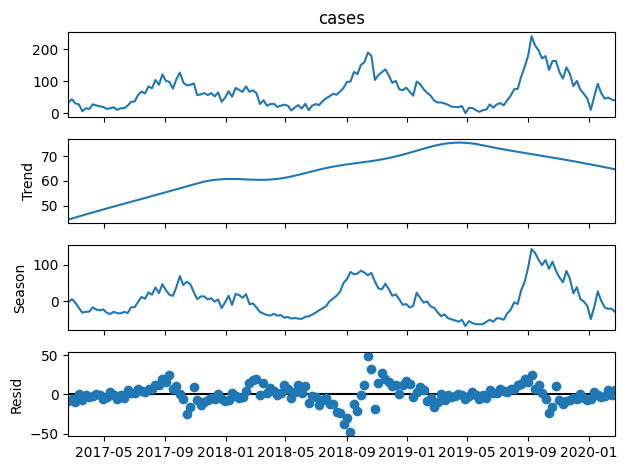

In [13]:
# stl = STL(mnl_model_data['cases'], seasonal=53)
# result = stl.fit()

# # Create a larger and improved plot
# # plt.style.use('ggplot')
# fig = result.plot()
# fig.set_size_inches(10, 6)
# fig.suptitle("STL Decomposition of Dengue Cases in Manila City", fontsize=16)
# # Improve layout and font sizes
# fig.tight_layout()
# for ax in fig.axes:
#     ax.set_xlabel(ax.get_xlabel(), fontsize=12)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=12)
#     ax.title.set_fontsize(14)

# plt.show()
stl = STL(mnl_model_data['cases'], seasonal=53)
result = stl.fit()
result.plot()
plt.show()

In [14]:
qc_model_data = NCR_model_data[NCR_model_data['loc'] == 'QUEZON CITY']
weeks_lag = [1, 5, 26, 52]
for lag in weeks_lag:
    qc_model_data[f"cases {lag}w lag"] = qc_model_data['cases'].shift(lag)
    # NCR_data[f"adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].shift(lag)
    qc_model_data[f"6w skew cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).skew()
    qc_model_data[f"6w std cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).std()
    qc_model_data[f"6wma cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).mean()
    # NCR_data[f"3wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=3).mean()
    # NCR_data[f"6wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=6).mean()
qc_model_data.dropna(inplace=True)
qc_model_data.set_index('date',inplace=True)
qc_model_data.drop(columns = ['loc'],inplace=True)
qc_model_data = qc_model_data.apply(pd.to_numeric, errors='coerce')
qc_model_data = qc_model_data[qc_model_data.index < '2020-03-01']
qc_model_data = qc_model_data.asfreq('W')
qc_model_data['cases'] = qc_model_data['cases'].interpolate()
qc_model_data.head(10)


D:\Temp\ipykernel_280\1669783366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_model_data[f"cases {lag}w lag"] = qc_model_data['cases'].shift(lag)
D:\Temp\ipykernel_280\1669783366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_model_data[f"6w skew cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).skew()
D:\Temp\ipykernel_280\1669783366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,cases,month,cases 1w lag,6w skew cases 1w lag,6w std cases 1w lag,6wma cases 1w lag,cases 5w lag,6w skew cases 5w lag,6w std cases 5w lag,6wma cases 5w lag,cases 26w lag,6w skew cases 26w lag,6w std cases 26w lag,6wma cases 26w lag,cases 52w lag,6w skew cases 52w lag,6w std cases 52w lag,6wma cases 52w lag
date,,,,,,,,,,,,,,,,,,
2017-02-19,95.0,2.0,113.0,0.128307,24.383738,107.166667,143.0,2.217689,30.277054,82.500000,205.0,0.051854,58.312091,146.500000,75.0,-1.162302,9.246621,74.500000
2017-02-26,92.0,2.0,95.0,0.967855,19.353725,110.833333,93.0,1.776708,29.716999,86.500000,163.0,-0.596814,51.097619,158.833333,62.0,-0.706651,7.859177,75.166667
2017-03-05,91.0,3.0,92.0,1.037519,12.323419,102.333333,122.0,0.915321,29.437504,96.833333,199.0,-0.692853,34.336084,178.833333,55.0,-0.410537,10.666146,70.833333
2017-03-12,94.0,3.0,91.0,0.982777,12.649111,102.000000,99.0,0.715473,26.606390,101.500000,0.0,-2.074759,80.382627,158.166667,55.0,-0.228164,9.683319,65.833333
2017-03-19,0.0,3.0,94.0,1.870798,8.164966,97.333333,113.0,0.128307,24.383738,107.166667,168.0,-2.089804,80.425742,158.500000,52.0,0.588286,10.347302,62.333333
2017-03-26,96.0,3.0,0.0,-2.213029,40.424827,80.833333,95.0,0.967855,19.353725,110.833333,2.0,-0.840569,95.806924,122.833333,41.0,0.491460,11.290114,56.666667
2017-04-02,97.0,4.0,96.0,-2.436573,38.257025,78.000000,92.0,1.037519,12.323419,102.333333,177.0,-0.887008,91.593486,118.166667,35.0,-0.627851,10.039920,50.000000
2017-04-09,66.0,4.0,97.0,-2.430120,38.443031,78.333333,91.0,0.982777,12.649111,102.000000,0.0,0.042732,99.470599,91.000000,46.0,-0.622538,8.164966,47.333333
2017-04-16,46.0,4.0,66.0,-2.013722,38.057851,74.000000,94.0,1.870798,8.164966,97.333333,165.0,0.007254,92.834620,85.333333,27.0,-0.401357,10.557778,42.666667


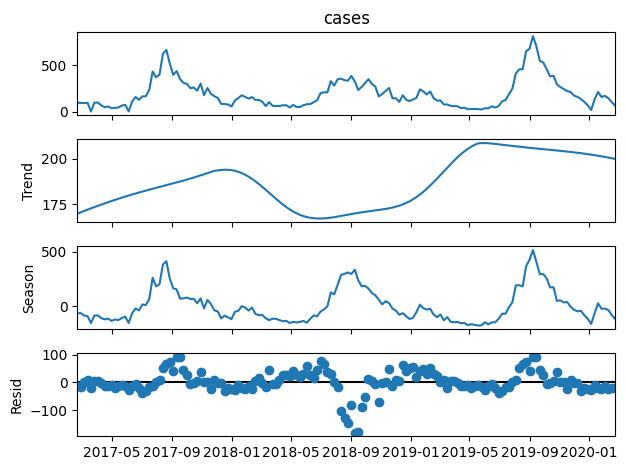

In [15]:
# # Fit STL decomposition
# stl = STL(qc_model_data['cases'], seasonal=53)
# result = stl.fit()

# # Create a larger and improved plot
# # plt.style.use('ggplot')  # Apply a nice style
# fig = result.plot()
# fig.set_size_inches(10, 6)  # Increase figure size
# fig.suptitle("STL Decomposition of Dengue Cases in Quezon City", fontsize=16)
# # Improve layout and font sizes
# fig.tight_layout()
# for ax in fig.axes:
#     ax.set_xlabel(ax.get_xlabel(), fontsize=10)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=10)
#     ax.title.set_fontsize(12)

# plt.show()
stl = STL(qc_model_data['cases'], seasonal=53)
result = stl.fit()
result.plot()
plt.show()

d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Training fraction: 70% | Test MSE: 1151.1118


D:\Temp\ipykernel_280\3838460771.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


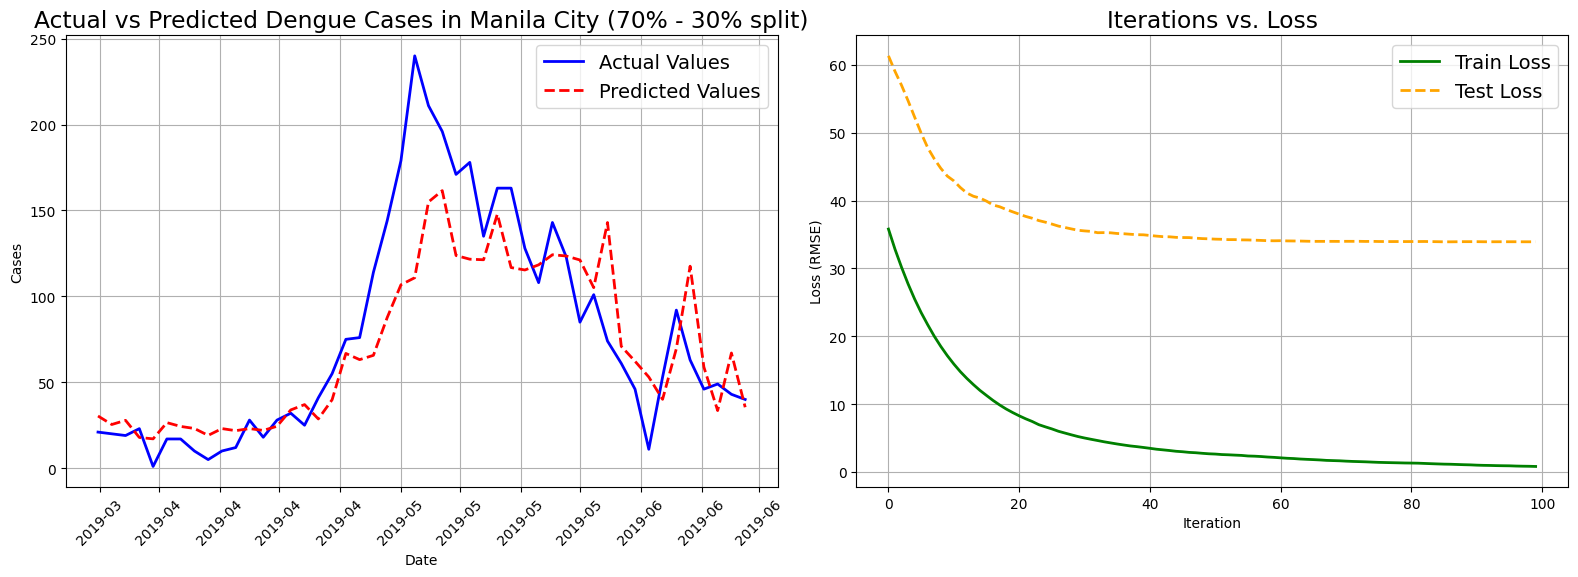

d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
D:\Temp\ipykernel_280\3838460771.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


Training fraction: 80% | Test MSE: 1643.9653


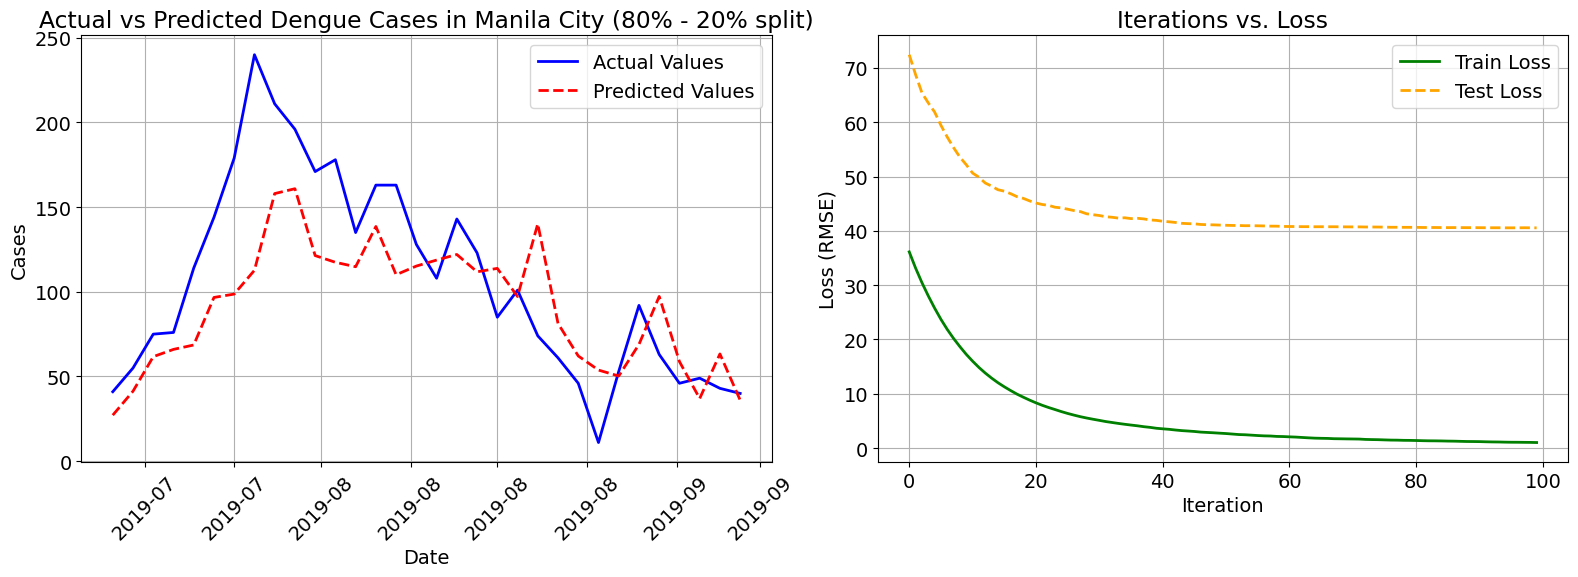

d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
D:\Temp\ipykernel_280\3838460771.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


Training fraction: 90% | Test MSE: 494.8660


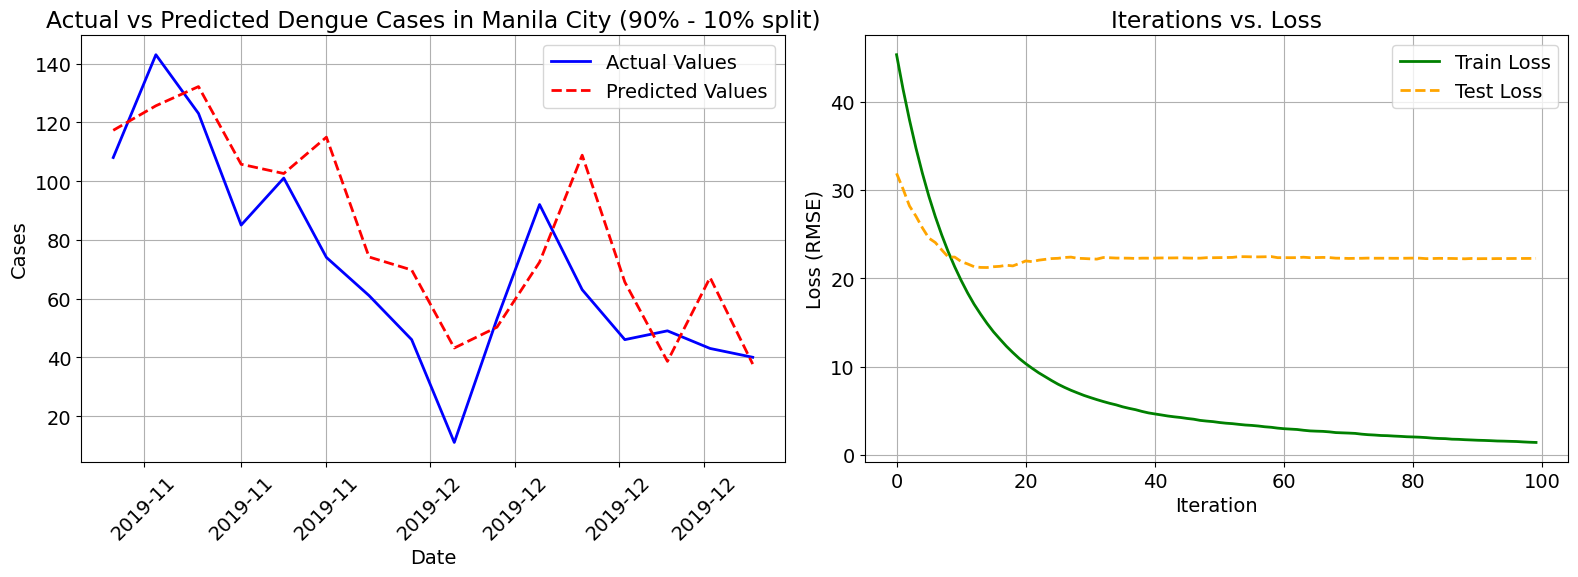

In [16]:
df =mnl_model_data
n = len(df)
fractions = [0.7, 0.8, 0.9]
# fractions = [0.6, 0.7, 0.8]
results = []

for frac in fractions:
    train_size = int(frac * n)
    # Use the first 'train_size' rows as the training set
    train_data = df.iloc[:train_size]
    # Use the remaining rows as the test set (if any)
    test_data = df.iloc[train_size:]
    
    # Prepare XGBoost DMatrix objects
    dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
    if not test_data.empty:
        dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
    else:
        dtest = None
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    # Define XGBoost parameters (adjust as needed)
    params = {
        'max_depth': 4,
        'eta': 0.1,
        'objective': 'reg:squarederror'  # Replace with your custom objective if needed
    }
    
    num_boost_round = 100
    # model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
    model = xgb.train(params, dtrain,num_boost_round, watchlist, evals_result=evals_result, verbose_eval=False)
    
    # Evaluate the model on test data if available
    if dtest is not None:
        preds = model.predict(dtest)
        mse = mean_squared_error(test_data['cases'], preds)
        results.append((frac, mse))
        print(f"Training fraction: {frac*100:.0f}% | Test MSE: {mse:.4f}")
    else:
        results.append((frac, None))
        print(f"Training fraction: {frac*100:.0f}% | No test data available.")
# 'results' now holds the training fraction and corresponding test MSE values.
# Create a figure with 1 row and 2 columns of subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plt.rcParams.update({'font.size': 14})
    # Left subplot: Actual vs. Predicted Dengue Cases
    ax[0].plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=2)
    ax[0].plot(test_data.index, preds, label='Predicted Values', color='red', linestyle='--', linewidth=2)
    ax[0].set_title(f'Actual vs Predicted Dengue Cases in Manila City ({frac*100:.0f}% - {(1-frac)*100:.0f}% split)')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Cases')
    ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)
    ax[0].legend()
    ax[0].grid(True)

    # Right subplot: Iterations vs. Custom Loss (MAE)
    # Assume that evals_result contains our custom evaluation metric 'mae'
    epochs = len(evals_result['train']['rmse'])
    x_axis = range(epochs)
    ax[1].plot(x_axis, evals_result['train']['rmse'], label='Train Loss', color='green', linewidth=2)
    ax[1].plot(x_axis, evals_result['eval']['rmse'], label='Test Loss', color='orange', linestyle='--', linewidth=2)
    ax[1].set_title('Iterations vs. Loss')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss (RMSE)')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
df =mnl_model_data
n = len(df)

train_size = int(0.9 * n)
# Use the first 'train_size' rows as the training set
train_data = df.iloc[:train_size]
# Use the remaining rows as the test set (if any)
test_data = df.iloc[train_size:]

# Prepare XGBoost DMatrix objects
dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
if not test_data.empty:
    dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
else:
    dtest = None
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
# Define XGBoost parameters (adjust as needed)
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'reg:squarederror'  # Replace with your custom objective if needed
}

num_boost_round = 100
# model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
model = xgb.train(params, dtrain,num_boost_round, watchlist, evals_result=evals_result, verbose_eval=False)


preds = model.predict(dtest)
        


d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [18]:
forecasted = forecast(model=model,data = train_data,weeks_ahead=len(test_data))

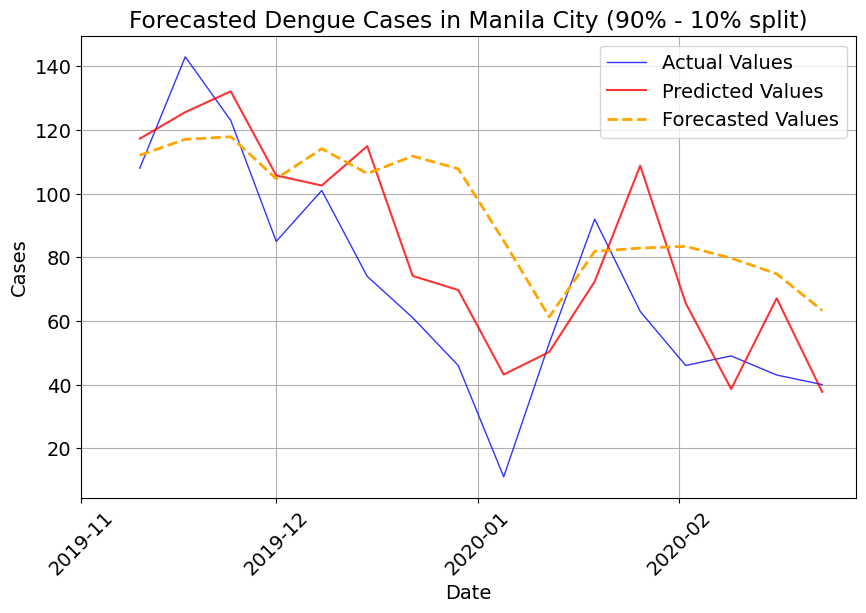

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=1, alpha=0.8)
plt.plot(test_data.index, preds, label='Predicted Values', color='red', linewidth=1.5, alpha=0.8)
plt.plot(forecasted.index, forecasted['cases'], label='Forecasted Values', color='orange', linestyle='--', linewidth=2)
plt.title(f'Forecasted Dengue Cases in Manila City (90% - 10% split)')
plt.xlabel('Date')
plt.xticks([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Ticks at the start of each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
qc_model_data = NCR_model_data[NCR_model_data['loc'] == 'QUEZON CITY']
weeks_lag = [1, 5, 26, 52]
for lag in weeks_lag:
    qc_model_data[f"cases {lag}w lag"] = qc_model_data['cases'].shift(lag)
    # NCR_data[f"adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].shift(lag)
    qc_model_data[f"6w skew cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).skew()
    qc_model_data[f"6w std cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).std()
    qc_model_data[f"6wma cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).mean()
    # NCR_data[f"3wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=3).mean()
    # NCR_data[f"6wma adj_cases {lag}w lag"] = NCR_data['adjacent_cases'].rolling(window=6).mean()
qc_model_data.dropna(inplace=True)
qc_model_data.set_index('date',inplace=True)
qc_model_data.drop(columns = ['loc'],inplace=True)
qc_model_data = qc_model_data.apply(pd.to_numeric, errors='coerce')
qc_model_data = qc_model_data[qc_model_data.index < '2020-03-01']
qc_model_data = qc_model_data.asfreq('W')
qc_model_data['cases'] = qc_model_data['cases'].interpolate()
qc_model_data.head()


D:\Temp\ipykernel_280\1522072324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_model_data[f"cases {lag}w lag"] = qc_model_data['cases'].shift(lag)
D:\Temp\ipykernel_280\1522072324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_model_data[f"6w skew cases {lag}w lag"] = qc_model_data['cases'].shift(lag).rolling(window=6).skew()
D:\Temp\ipykernel_280\1522072324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,cases,month,cases 1w lag,6w skew cases 1w lag,6w std cases 1w lag,6wma cases 1w lag,cases 5w lag,6w skew cases 5w lag,6w std cases 5w lag,6wma cases 5w lag,cases 26w lag,6w skew cases 26w lag,6w std cases 26w lag,6wma cases 26w lag,cases 52w lag,6w skew cases 52w lag,6w std cases 52w lag,6wma cases 52w lag
date,,,,,,,,,,,,,,,,,,
2017-02-19,95.0,2.0,113.0,0.128307,24.383738,107.166667,143.0,2.217689,30.277054,82.500000,205.0,0.051854,58.312091,146.500000,75.0,-1.162302,9.246621,74.500000
2017-02-26,92.0,2.0,95.0,0.967855,19.353725,110.833333,93.0,1.776708,29.716999,86.500000,163.0,-0.596814,51.097619,158.833333,62.0,-0.706651,7.859177,75.166667
2017-03-05,91.0,3.0,92.0,1.037519,12.323419,102.333333,122.0,0.915321,29.437504,96.833333,199.0,-0.692853,34.336084,178.833333,55.0,-0.410537,10.666146,70.833333
2017-03-12,94.0,3.0,91.0,0.982777,12.649111,102.000000,99.0,0.715473,26.606390,101.500000,0.0,-2.074759,80.382627,158.166667,55.0,-0.228164,9.683319,65.833333
2017-03-19,0.0,3.0,94.0,1.870798,8.164966,97.333333,113.0,0.128307,24.383738,107.166667,168.0,-2.089804,80.425742,158.500000,52.0,0.588286,10.347302,62.333333


d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
D:\Temp\ipykernel_280\2448596129.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


Training fraction: 70% | Test MSE: 5887.8498


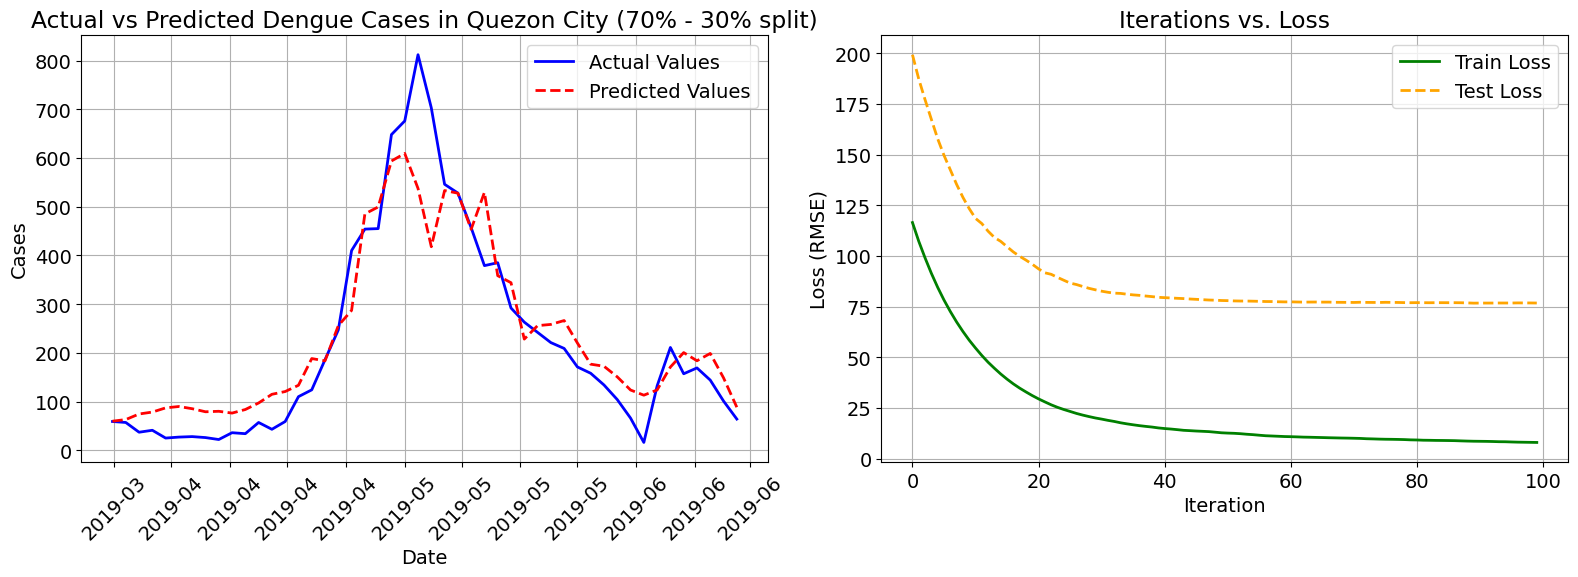

d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
D:\Temp\ipykernel_280\2448596129.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


Training fraction: 80% | Test MSE: 8235.2092


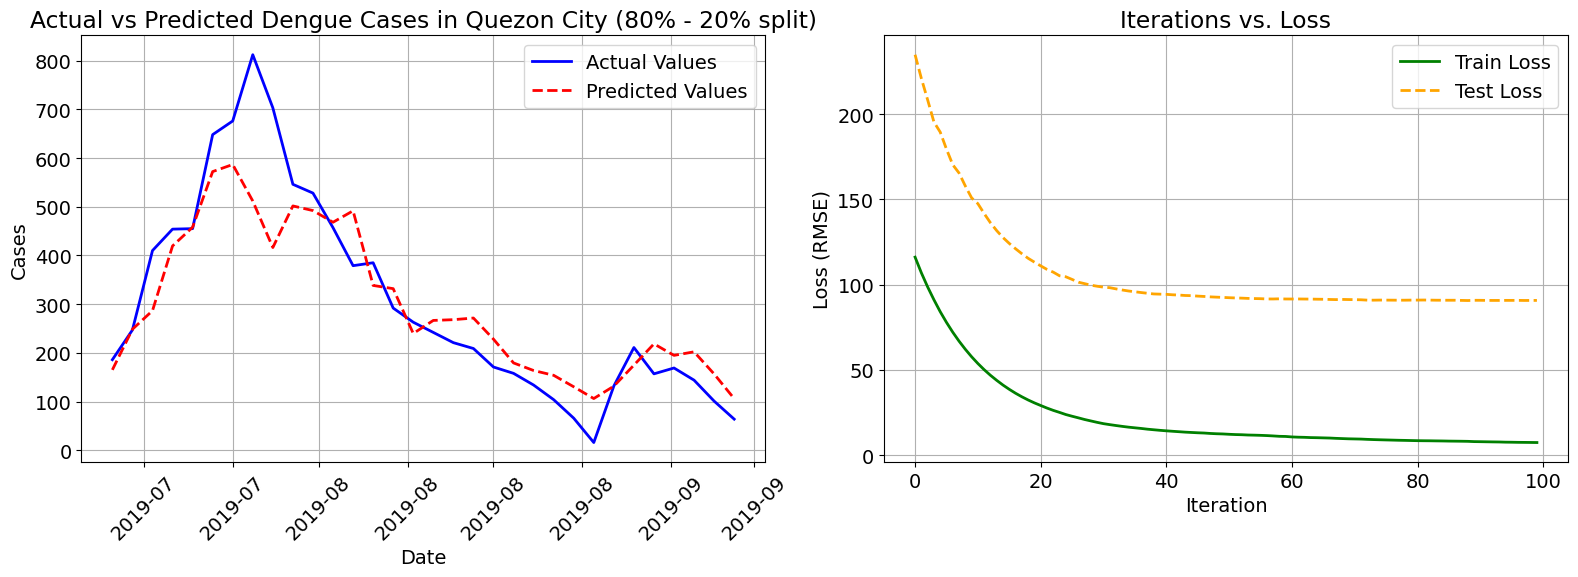

d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
D:\Temp\ipykernel_280\2448596129.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)


Training fraction: 90% | Test MSE: 2838.3908


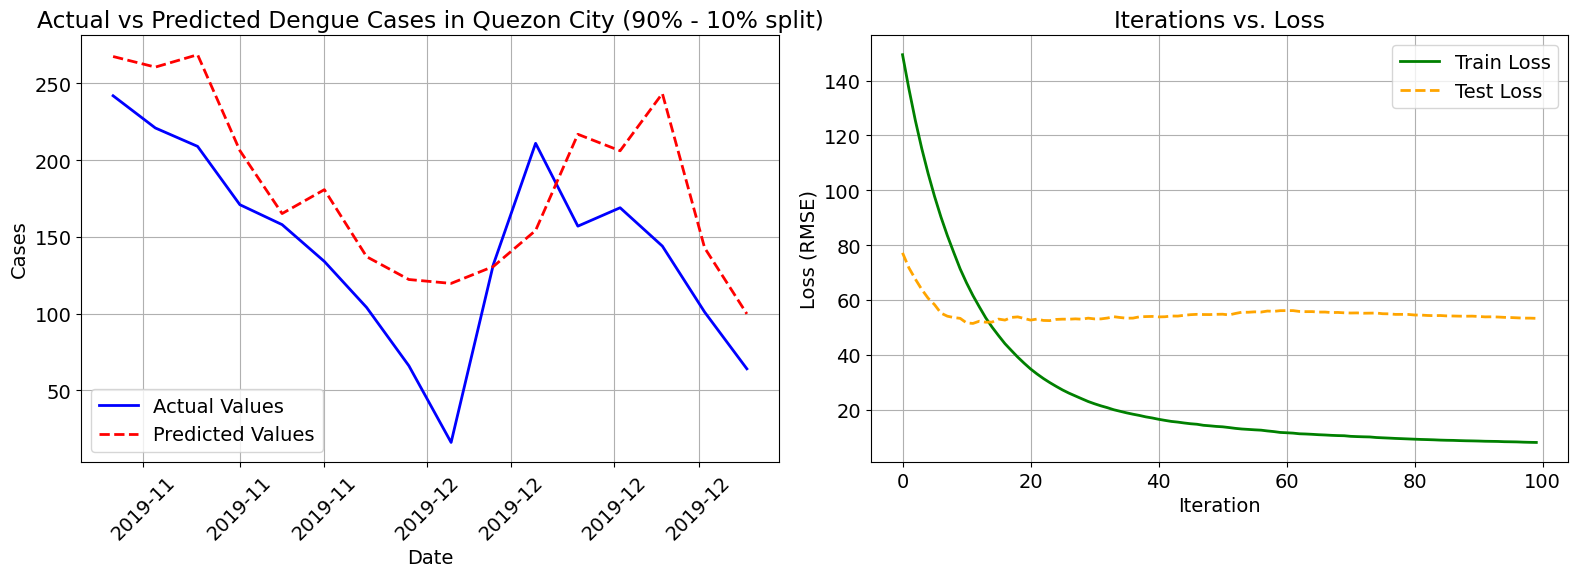

In [21]:

df =qc_model_data
n = len(df)
fractions = [0.7, 0.8, 0.9]
# fractions = [0.6, 0.7, 0.8]
results = []

for frac in fractions:
    train_size = int(frac * n)
    # Use the first 'train_size' rows as the training set
    train_data = df.iloc[:train_size]
    # Use the remaining rows as the test set (if any)
    test_data = df.iloc[train_size:]
    
    # Prepare XGBoost DMatrix objects
    dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
    if not test_data.empty:
        dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
    else:
        dtest = None
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    # Define XGBoost parameters (adjust as needed)
    params = {
        'max_depth': 4,
        'eta': 0.1,
        'objective': 'reg:squarederror'  # Replace with your custom objective if needed
    }
    
    num_boost_round = 100
    # model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
    model = xgb.train(params, dtrain,num_boost_round, watchlist, evals_result=evals_result, verbose_eval=False)
    
    # Evaluate the model on test data if available
    if dtest is not None:
        preds = model.predict(dtest)
        mse = mean_squared_error(test_data['cases'], preds)
        results.append((frac, mse))
        print(f"Training fraction: {frac*100:.0f}% | Test MSE: {mse:.4f}")
    else:
        results.append((frac, None))
        print(f"Training fraction: {frac*100:.0f}% | No test data available.")
# 'results' now holds the training fraction and corresponding test MSE values.
# Create a figure with 1 row and 2 columns of subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plt.rcParams.update({'font.size': 14})
    # Left subplot: Actual vs. Predicted Dengue Cases
    ax[0].plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=2)
    ax[0].plot(test_data.index, preds, label='Predicted Values', color='red', linestyle='--', linewidth=2)
    ax[0].set_title(f'Actual vs Predicted Dengue Cases in Quezon City ({frac*100:.0f}% - {(1-frac)*100:.0f}% split)')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Cases')
    ax[0].set_xticklabels([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)
    ax[0].legend()
    ax[0].grid(True)

    # Right subplot: Iterations vs. Custom Loss (MAE)
    # Assume that evals_result contains our custom evaluation metric 'mae'
    epochs = len(evals_result['train']['rmse'])
    x_axis = range(epochs)
    ax[1].plot(x_axis, evals_result['train']['rmse'], label='Train Loss', color='green', linewidth=2)
    ax[1].plot(x_axis, evals_result['eval']['rmse'], label='Test Loss', color='orange', linestyle='--', linewidth=2)
    ax[1].set_title('Iterations vs. Loss')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss (RMSE)')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


In [22]:
df =qc_model_data
n = len(df)

train_size = int(0.9 * n)
# Use the first 'train_size' rows as the training set
train_data = df.iloc[:train_size]
# Use the remaining rows as the test set (if any)
test_data = df.iloc[train_size:]

# Prepare XGBoost DMatrix objects
dtrain = xgb.DMatrix(train_data.drop('cases', axis=1), label=train_data['cases'])
if not test_data.empty:
    dtest = xgb.DMatrix(test_data.drop('cases', axis=1), label=test_data['cases'])
else:
    dtest = None
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
# Define XGBoost parameters (adjust as needed)
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'reg:squarederror'  # Replace with your custom objective if needed
}

num_boost_round = 100
# model = xgb.train(params, dtrain, num_boost_round=num_boost_round, obj=generalized_huber_loss)
model = xgb.train(params, dtrain,num_boost_round, watchlist, evals_result=evals_result, verbose_eval=False)


preds = model.predict(dtest)
        


d:\Philippine-Dengue-Cases-Forecasting\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [23]:
forecasted = forecast(model=model,data = train_data,weeks_ahead=len(test_data))

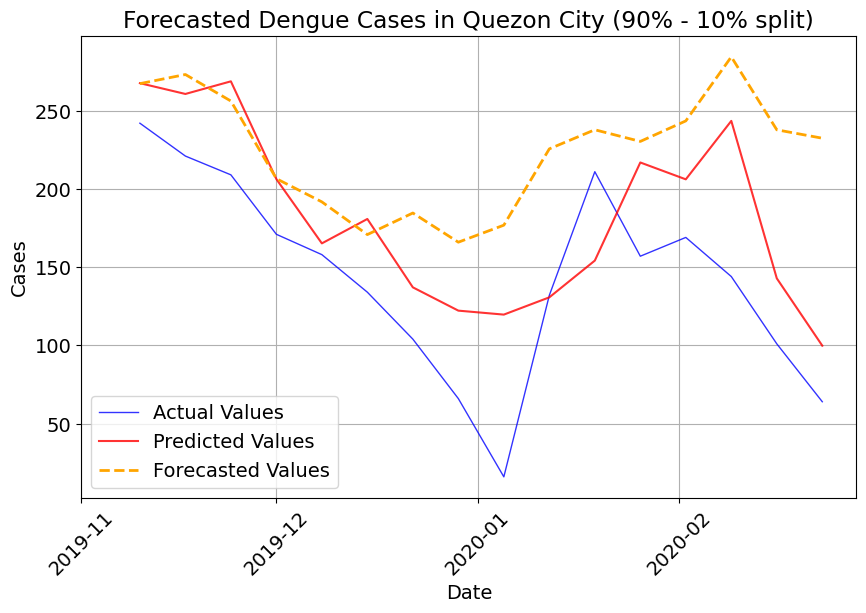

In [24]:

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['cases'], label='Actual Values', color='blue', linewidth=1, alpha=0.8)
plt.plot(test_data.index, preds, label='Predicted Values', color='red', linewidth=1.5, alpha=0.8)
plt.plot(forecasted.index, forecasted['cases'], label='Forecasted Values', color='orange', linestyle='--', linewidth=2)
plt.title(f'Forecasted Dengue Cases in Quezon City (90% - 10% split)')
plt.xlabel('Date')
plt.xticks([d.strftime('%Y-%m') for d in test_data.index], rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Ticks at the start of each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.show()